## Sesión 4. Implementando el modelo Miller-Orr

** Un modelo estocástico ** = conjunto de reglas de decisión para controlar el saldo de una cuenta. Normalmente están basados en límites de control de manera que cuando cierto nivel de caja es superado (o por arriba o por abajo) se ejecuta una acción de control que lleva el saldo a un nivel de caja objetivo.

¿Por qué un modelo estocástico? No hay que esperar a que el nivel de caja esté en cero para ejecutar una acción de control. La incertidumbre sobre el futuro nos obliga a disponer de cierto nivel de caja por motivos de precaución. Para ello es necesario estudiar las propiedades estadísticas de los flujos de caja a los que nos enfrentamos.

¿Los modelos estocásticos y deterministas, pueden convivir? Pueden y deben convivir. Podemos separar los flujos de caja mayores (deterministas) de los menores (estocásticos). Aplicar los dos modelos y agregar los dos planes de tesorería.

Figura del modelo de Miller-Orr. Modelo de tres niveles basado en dos activos: una cuenta de efectivo y una cuenta de inversiones financieras temporales disponibles. Vamos a programar el modelo de Miller-Orr que es lo mismo que programar la siguiente función:

$$x_t=\left\{\begin{array}{lll}z-b_{t-1}, & \mbox{if} & b_{t-1} > h \\ 0, &\mbox{if} & l<b_{t-1}<h  \\z-b_{t-1}, & \mbox{if} & b_{t-1} < l. \end{array}\right. $$

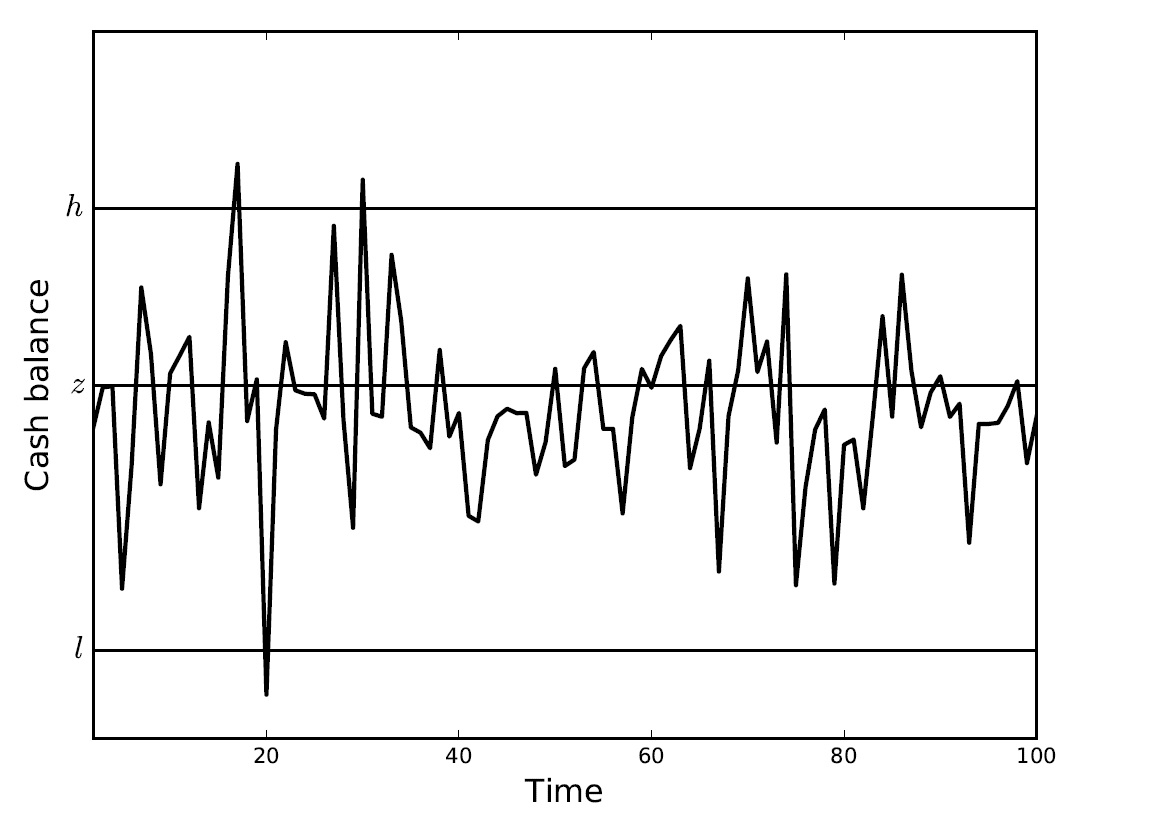

In [1]:
from IPython.display import Image
Image(filename = "Miller.jpg", embed = True, width = 500, height = 500)

In [2]:
# Importamos librerías numpy y matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Definimos una funcion transfer que obtiene una transacción a partir de un saldo inicial bal y tres niveles h, z y l
# según modelo Miller-Orr con if, elif, else.  Incluir comentarios para docstring con comillas triples.
def transfer(H, Z, L, s):
    """Calcular la transacción x partir H, Z y L para un saldo s"""
    if s > H:
        x = Z - s
    elif s < L:
        x = Z - s
    else:
        x = 0
    return(x)

In [12]:
# Para comprobar que funciona damos valores a h=100, z=80 y l=60.
H = 100
Z = 80
L = 60
H, Z, L

(100, 80, 60)

In [13]:
# Partiendo de b0 = 50 el resultado de transfer debe ser 30. Comprobar docstring con Shift+Tab
transfer(H, Z, L, 50)

30

**Ejercicio.** Si te das cuenta la acción de control x es la misma tanto si estamos por encima de h como si estamos por debajo de l. Define una función transfer2 de manera que la instrucción if compruebe las dos condiciones.

In [14]:
# Función transfer 2 con if-else-or
def transfer2(H, Z, L, s):
    """Calcular la transacción x partir H, Z y L para un saldo s"""
    if s > H or s < L:
        x = Z - s
    else:
        x = 0
    return(x)

In [15]:
# Comprobamos que devuelve el mismo resultado
transfer2(H, Z, L, 50)

30

¿Y cómo se calculan estos niveles de control del modelo de Miller? El autor nos da dos fórmulas para calcular los niveles a partir de los costes de transacción y mantenimiento.

$$ z = l + \sqrt[3]{\frac{3 \gamma_0 \sigma^2}{v^+}} $$

$$ h = 3z - 2l $$

donde $\sigma$ es la desviación típica de un flujo de caja normal, $\gamma_0$ es el coste fijo de transacción y $v^+$ es el coste de mantener una unidad monetaria en efectivo (coste de oportunidad por no estar obteniendo una rentabilidad $v^+$ si invirtiéramos ese dinero en un activo a corto plazo más rentable). 

In [28]:
# Introducimos datos de partida l = 0, g0 = 5, sigma = 0.01, vpos = 0.001
L = 0
g0 = 5
sigma = 0.01
vpos = 0.001

In [29]:
# Calculamos Z, H a partir de las fórmulas y presentamos H, Z y L
Z = L + ((3 * g0 * sigma ** 2)/vpos)**(1/3)
H = 3 * Z - 2 * L 
H, Z, L

(3.434142727659996, 1.1447142425533319, 0)

Ya sabemos como calcular los límites de control y las transferencias. Ahora habría que calcular los costes de un plan de tesorería aplicado sobre un horizonte de planificación. Para esto tendremos que programar las funciones de cálculo de costes de transacción y mantenimiento.

$$ \Gamma(x_t) = \left\{\begin{array}{lll} \gamma_0 + \gamma_ 1 \cdot x_t & \mbox{si} & x_t > 0 \\ 0 & \mbox{si} & x_t = 0 \\ \gamma_0 - \gamma_ 1 \cdot x_t & \mbox{si} & x_t < 0 \end{array}\right.$$

$$ H(b_t) = \left\{\begin{array}{lll} v^+ \cdot b_t & \mbox{si} & b_t \geq 0 \\ -v^- \cdot b_t & \mbox{si} & b_t <0. \end{array}\right.$$ 

In [16]:
# Definimos una funcion costetrans a partir de x, gamma0 y gamma1. ctrans = 0, Si x>0, elif x<0, return ctrans
def costetrans(x, g0, g1):
    ctrans = 0
    if x > 0:
        ctrans = g0 + g1 * x
    elif x < 0:
        ctrans = g0 - g1 * x
    return(ctrans)

In [17]:
# Comprobamos costetrans con x = -100, g0 = 10 y g1 = 0.01. Resultado 11
costetrans(-100, 10, 0.01)

11.0

In [19]:
# Definimos costeman a partir de un saldo b y un coste de mantenimiento vpos o vneg"""
def costeman(b, vpos, vneg):
    if b >= 0:
        cman = vpos * b
    else:
        cman = -vneg * b
    return(cman)

In [20]:
# Comprobamos costeman con b = -100, vpos = 0.01 y vneg = 0.3. Resultado 30
costeman(-100, 0.01, 0.3)

30.0

Estos son costes para cada período del horizonte de planificación pero para calcular el coste total necesitamos una ecuación que nos relacione el saldo de caja entre períodos consecutivos:

$$ b_t = b_{t-1} + x_t + f_t $$

In [36]:
# Definimos una funcion costes que Calcula el coste total para un flujo de caja f partiendo de un saldo inicial ini
# Los parámetros de entrada son h, z, l, g0, g1, vpos, vneg, f e ini
# Primero inibal = ini, costes=[] y para cada elemento de f utilizamos la función transfer para calcular x
# Luego actualizamos bal según ecuación bal =  inibal + x + elem y append los dos costes costetrans y costeman a lista costes
def costes(h, z, l, g0, g1, vpos, vneg, f, ini):
    inibal = ini
    coste = []
    for elem in f:
        x = transfer(h, z, l, inibal)
        ctrans = costetrans(x, g0, g1)
        bal = inibal + x + elem
        cman = costeman(bal, vpos, vneg)
        coste.append(ctrans + cman)
        inibal = bal
    return(coste)

In [38]:
# Para comprobar que funciona creamos una lista de flujo aleatorio normal (0,2) de longitud 5 con nombre flow
np.random.seed(1)
flow = np.random.normal(0, 2, 5)
flow

array([ 3.24869073, -1.22351283, -1.0563435 , -2.14593724,  1.73081526])

In [32]:
# Presentamos H, Z y L para recordar valores
H = 3.4
Z = 1.14
L = 0

In [34]:
# Fijamos b0 a z y valores g0 = 5, g1 = 0.0, vpos = 0.001 y vneg = 0.3
b0 = Z
g1 = 0.0
g0 = 5
sigma = 0.01
vpos = 0.001
vneg = 0.3

In [39]:
# Calculamos costes y los asignamos a la lista c
c = costes(H, Z, L, g0, g1, vpos, vneg, flow, b0)
c

[0.0043886907273264835,
 5.0250538481900451,
 5.0000836564954732,
 0.61868422465177564,
 5.0028708152586496]

In [41]:
# Podemos calular el total, la media, max, min y std
np.sum(c), np.mean(c), np.max(c), np.min(c), np.std(c)

(15.651081235323272,
 3.1302162470646544,
 5.0250538481900451,
 0.0043886907273264835,
 2.3096423881991384)

In [42]:
# Podemos asignar c a una Series de pandas y utilizar describe
serie = pd.Series(c)
serie.describe()

count    5.000000
mean     3.130216
std      2.582259
min      0.004389
25%      0.618684
50%      5.000084
75%      5.002871
max      5.025054
dtype: float64

En la función costes hemos utilizado transfer para calcular costes a partir de las acciones de control x. De manera muy similar, podemos definir una función que nos devuelva nuestro plan de tesorería con la secuencia de acciones de control.

In [43]:
# Función plan que devuelve el plan de tesorería
def plan(h, z, l, f, ini):
    inibal = ini
    plan = []
    for elem in f:
        x = transfer(h, z, l, inibal)
        plan.append(x)
        bal = inibal + x + elem
        inibal = bal
    return(plan)

In [44]:
# Comprobamos que funciona almacenado en X mayúscula el plan para H, Z, L, flow y b0 = z
X = plan(H, Z, L, flow, b0)
X

[0, -3.2486907273264833, 1.223512827300151, 0, 3.202280748839252]

** Ejercicio **. Define una función balance que calcule el saldo bancario para flujo de caja f y saldo inicial ini aplicando el modelo de Miller-Orr.

In [45]:
# Función balance que devuelve el saldo saldo bancario
def balance(h, z, l, f, ini):
    inibal = ini
    balance = []
    for elem in f:
        x = transfer(h, z, l, inibal)
        bal = inibal + x + elem
        balance.append(bal)
        inibal = bal
    return(balance)

In [46]:
# Comprobamos que funciona almacenado en B mayúscula el saldo bancario para para b0 = Z
B = balance(H, Z, L, flow, b0)
B

[4.388690727326483,
 -0.083512827300151082,
 0.08365649547308851,
 -2.0622807488392523,
 2.8708152586493565]

In [48]:
%matplotlib inline

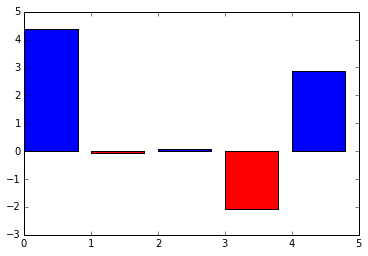

In [49]:
# Representamos balpos y balneg en gráfico de barras a partir con max(i, 0) para i in B
balpos = [max(i, 0) for i in B]
balneg = [min(i, 0) for i in B]
t = range(len(B))
plt.bar(t, balpos)
plt.bar(t, balneg, color='r')
plt.show()

** Concepto de clase. ** En programación orientada a objetos, una clase es un conjunto de métodos y atributos que definen el comportamiento y el estado de un objeto. Algo así como crear un molde para hacer galletas de una determinada forma que podemos utilizar cuando queramos.

A nosotros nos va a servir para empaquetar todas las funciones (transfer, costes, plan, balance) del Modelo de Miller-Orr y sus atributos principales (H, Z, L, y los costes de transacción y mantenimiento). De esta manera podremos crear un o varios modelos de este tipo cuando queramos.

In [63]:
# class miller(object):
class miller(object):

    # def __init__(self, g0, g1, vpos, vneg, H, Z, L) y y añadimos listacoste =[], plan=[] y balance=[]
    def __init__(self, g0, g1, vpos, vneg, H, Z, L):
        self.g0 = g0
        self.g1 = g1
        self.vpos = vpos
        self.vneg = vneg
        self.H = H
        self.Z = Z
        self.L = L
        self.listacoste = []
        self.plan = []
        self.balance = []

# def transfer(self, b0)

    def transfer(self, b0):
        if b0 > self.H or b0 < self.L:
            x = b0 - self.Z
        else:
            x = 0
        return(x)

# def costetrans(self, x)

    def costetrans(self, x):
        ctrans = 0
        if x > 0:
            ctrans = self.g0 + self.g1 * x
        elif x < 0:
            ctrans = self.g0 - self.g1 * x
        return(ctrans)
        
# def costeman(self, b)

    def costeman(self, b):
        if b >= 0:
            cman = self.vpos * b
        else:
            cman = -self.vneg * b
        return(cman)

# def costes(self, f, b0)  # Añadimos self.plan.append y self.balance.append

    def costes(self, f, b0):
        inibal = b0
        del self.listacoste[:]
        del self.plan[:]
        del self.balance[:]
        for elem in f:
            x = self.transfer(inibal)
            self.plan.append(x)
            bal = inibal + x + elem
            self.balance.append(bal)
            self.listacoste.append(self.costetrans(x) + self.costeman(bal))
            inibal = bal
        return(self.listacoste)

In [69]:
# Creamos un modelo de miller que llamamos modelo
modelo = miller(g0, g1, vpos, vneg, H, Z, L)
modelo2 = miller(g0, g1, vpos, vneg, 2*H, 2*Z, 2*L)

In [65]:
flow

array([ 3.24869073, -1.22351283, -1.0563435 , -2.14593724,  1.73081526])

In [66]:
# Calculamos costes llamando a modelo.costes(flow, b0)
modelo.costes(flow, 0)

[0.0032486907273264836,
 0.0020251779000263329,
 0.00096883439549942142,
 0.35313085464387589,
 5.5290171316929442]

In [67]:
# Extraemos la propiedad modelo.plan
modelo.plan

[0, 0, 0, 0, -2.3171028488129197]

In [68]:
# Obtenmos el saldo bancario con modelo.balance
modelo.balance

[3.2486907273264833,
 2.0251779000263328,
 0.96883439549942141,
 -1.1771028488129196,
 -1.7633904389764823]

** Ejercicio. ** Construir una clase para el modelo de Gormley con 4 niveles de control estáticos y que utiliza previsiones de flujo de caja como entradas. El saldo de caja se mueve entre dos límites: uno superior $D$ y otro inferior $V$. Cuando el saldo más la previsión para el próximo periodo supera el límite $V$ se ejecuta una acción de control $x_t$ que lleva el saldo a $v$ minúscula. Y cuando el saldo más la previsión para el próximo periodo cae por dabajo del límite $D$ se ejecuta una acción de control $x_t$ que lleva el saldo a $d$ minúscula. 


$$x_t=\left\{\begin{array}{lll}v_{t}-\hat{b}_{t-1}-\hat{f}_{t}, & \mbox{if} & \hat{b}_{t-1}+\hat{f}_{t}> V_{t}, \\ 0, & &\mbox{otherwise,}  \\d_{t}-\hat{b}_{t-1}-\hat{f}_{t}, & \mbox{if} & \hat{b}_{t-1}+\hat{f}_{t}<D_{t}\end{array}\right.$$ 
